# Volume 4: River Crossing
    Benj McMullin
    Math 439
    2/23/2024

In [2]:
import numpy as np
from scipy.integrate import quad
from matplotlib import pyplot as plt
from scipy.interpolate import barycentric_interpolate as bary
from numpy import linalg as la
from scipy.optimize import root

# Problem 1
Assume that the current is given by $c(x) = −
\frac{7}{10} (x^2 − 1)$. (This function assumes, for example, that the current is faster near the center of the river.) Write a Python
function that accepts as arguments a function $y$, its derivative $y'$, and an $x$-value, and returns $L(x, y(x), y'(x))$ (where $T[y]=\int^1_{-1} L(x,y(x),y'(x))dx$ Use that function to defune a second
function that numerically computes $T[y]$ for a given path $y(x)$.

In [3]:
def first(y, dy, x):
    """
    Function to define the integrand for a given function y(x), its derivative dy(x),
    and a value of x.
    
    Parameters:
        y : callable
            Function representing y(x).
        dy : callable
            Function representing the derivative of y(x).
        x : float
            Value of x for which the integrand is evaluated.
    
    Returns:
        callable
            A lambda function representing the integrand.
    """
    # Define the function c(x) = -(7/10)*(x^2 - 1)
    c = lambda x: -(7/10)*(x**2 - 1)
    
    # Define the function alpha(x) = (1 - c(x)^2)^(-0.5)
    alpha = lambda x: (1 - c(x)**2)**(-0.5)
    
    # Return the integrand function
    return lambda x: alpha(x) * np.sqrt(1 + (alpha(x) * dy(x))**2) - (alpha(x)**2 * c(x) * dy(x))

def second(y, dy, x_val=0):
    """
    Function to perform numerical integration of the first function from -1 to 1,
    with a specified value of x.
    
    Parameters:
        y : callable
            Function representing y(x).
        dy : callable
            Function representing the derivative of y(x).
        x_val : float, optional
            Value of x at which the integration is performed. Default is 0.
    
    Returns:
        float
            The result of numerical integration.
    """
    # Perform numerical integration using quad function from scipy
    integration_result = quad(first(y, dy, x_val), -1, 1)[0]
    
    # Return the integration result
    return integration_result

# Problem 2

Let y(x) be the straight-line path between A = (−1, 0) and B = (1, 5). Numerically calculate T[y] to get an upper bound on the minimum time required to cross from A to
B. Using (18.2), find a lower bound on the minimum time required to cross.

In [4]:
# Define the interval [a, b] and the values of alpha and beta
a, b = -1, 1
alpha, beta = 0, 5
x0 = np.linspace(a, b, 100 + 1)

# Define the linear function y(x) using alpha, beta, 'a', and 'b'
y = lambda x: (beta - alpha) / (b - a) * (x - a) + alpha
dy = lambda x: 5 / 2 + 0 * x

# Call the 'second' function to perform numerical integration with the defined functions and x values
T = second(y, dy, x0)
print("Upper bound: ", T)

# Define a function representing a constant secant value of 1 for the lower bound
secant = lambda x: 1

# Calculate the lower bound of the integral using the quad function
lower_bound = quad(secant, -1, 1)[0]
print("Lower bound: ", lower_bound)

Upper bound:  3.8770820491384126
Lower bound:  2.0


# Problem 3

Numerically solve the Euler-Lagrange equation (18.4), using c(x) = −
7
10 (x
2 − 1)
and α = (1 − c
2
)
−1/2
, and y(−1) = 0, y(1) = 5.
Hint: Since this boundary value problem is defined over the doimain [−1, 1], it is easy to
solve using the pseudospectral method. Begin by replacing each d
dx with the pseudospectral
differentiation matrix D. Then impose the boundary conditions and solve.

In [5]:
def cheb(N):
    # Generate Chebyshev points
    x = np.cos((np.pi/N) * np.linspace(0, N, N + 1))
    x.shape = (N + 1, 1)  # Reshape x to a column vector
    
    # Generate a linearly spaced array from 0 to N
    lin = np.linspace(0, N, N + 1)
    lin.shape = (N + 1, 1)  # Reshape lin to a column vector
    
    # Initialize the coefficients vector
    c = np.ones((N + 1, 1))
    c[0], c[-1] = 2., 2.  # Modify the first and last coefficients
    c = c * (-1.)**lin  # Apply alternating signs to coefficients
    
    # Broadcast x to create a matrix X with Chebyshev points as columns
    X = x * np.ones(N + 1)
    
    # Compute the difference matrix dX
    dX = X - X.T
    
    # Compute the differentiation matrix D
    D = (c * (1. / c).T) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D.T, axis=0))  # Adjust the diagonal of D
    
    x.shape = (N + 1,)  # Restore the shape of x to a 1D array
    
    # Return the differentiation matrix D and the Chebyshev points
    return D, x

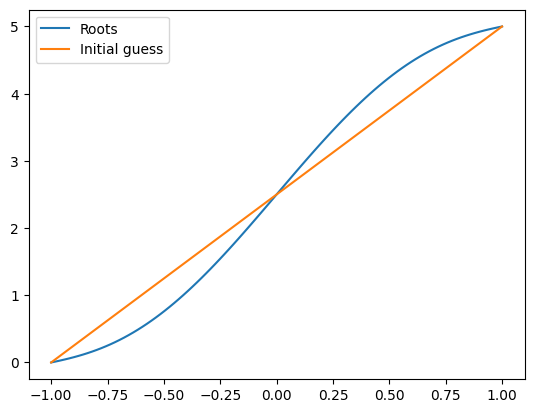

In [6]:
# Definition of the first differential operator
def first(dy, x):
    # Define the function c(x) = -(7/10)*(x^2 - 1)
    c = lambda x: -(7/10)*(x**2 - 1)
    
    # Define the function alpha(x) = (1 - c(x)^2)^(-0.5)
    alpha = lambda x: (1 - c(x)**2)**(-0.5)
    
    # Compute and return the result of the first differential operator
    return (alpha(x)**3) * dy * (1 + (alpha(x) * dy)**2)**(-0.5) - alpha(x)**2 * c(x)

# Generate Chebyshev differentiation matrix and Chebyshev points
D, x = cheb(5)

# Function to compute the derivative of the input function using the differentiation matrix D
def new_f(y):
    # Compute the derivative of y(x) using the differentiation matrix D
    dy = D @ y
    
    # Compute the chunk using the first differential operator
    chunk = first(dy, x)
    
    # Compute the big chunk by applying the differentiation matrix D to the chunk
    big_chunk = D @ chunk
    
    # Apply force conditions by modifying the boundary values of big_chunk
    big_chunk[0] -= y[0] - 5
    big_chunk[-1] -= y[-1]
    
    # Return the modified big_chunk
    return big_chunk

# Define the interval for the function
a, b = -1, 1
alpha, beta = 0, 5
x0 = np.linspace(a, b, 6)

# Define the initial guess function y(x) as a linear interpolation between alpha and beta
y = lambda x: (beta - alpha) / (b - a) * (x - a) + alpha

# Compute the initial guess values y0 for the function y(x)
y0 = y(x0)

# Find the roots of the function new_f using an initial guess y(x0)
roots = root(new_f, y(x0)).x

# Generate a finer grid for plotting
baryx = np.linspace(-1, 1, 100)

# Interpolate the function y(x) at the computed roots using barycentric interpolation
y = bary(x, roots, baryx)

# Plot the roots and the initial guess function
plt.plot(baryx, y, label="Roots")
plt.plot(x0, y0, label="Initial guess")
plt.legend()
plt.show()

# Problem 4

Plot the angle at which the boat should be pointed at each $x$-coordinate. (Hint: use Equation 1.1; see Figure 1.3. Note that the angle the boat should be steered is NOT described by the tangent vector to the trjaectory)

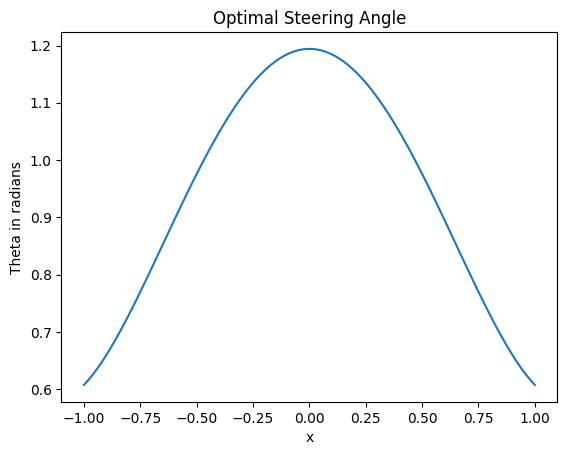

In [7]:
# Define the interval for the function
a, b = -1, 1
alpha, beta = 0, 5
x0 = np.linspace(a, b, 100)

# Define the function c(x) = -(7/10)*(x^2 - 1)
c = lambda x: -(7/10)*(x**2 - 1)

# Compute the derivative of the function at the computed roots
dy = D @ roots

# Initialize an empty list to store results
results = []

# Iterate over each index and corresponding x value in the array 'x'
for i, xvals in enumerate(x):
    # Define a function to find the optimal steering angle 'theta' using root-finding
    get_theta = lambda theta: c(xvals) * 1 / np.cos(theta) + np.tan(theta) - dy[i]
    
    # Use root-finding to find the root of the function 'get_theta' using an initial guess of np.arctan(dy[i])
    results.append(root(get_theta, np.arctan(dy[i])).x)

# Plot the optimal steering angle as a function of x
plt.plot(x0, bary(x, results, x0))
plt.title("Optimal Steering Angle")
plt.ylabel("Theta in radians")
plt.xlabel("x")
plt.show()